# Final Project: Load balancing
## Part 2 : Tabular Model-Free control

Author : Jed MOUTAHIR

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
class LoadBalencingEnv(object): 
    # Class that defines the environment with reward 0 and 1 with probability p.

    def __init__(self, lambdA, mu1, mu2, gamma, Q1_max, Q2_max):
        self.lambdA = lambdA
        self.mu1 = mu1
        self.mu2 = mu2
        self.gamma = gamma
        self.Q1 = 15
        self.Q2 = 15
        self.state = (self.Q1, self.Q2)

        self.actions = np.arange(2)     # define set of actions
        self.Q1_max = Q1_max
        self.Q2_max = Q2_max

    def reward(self):
        return self.state[0] + self.state[1]
    
    def step(self, action):
        # Take action (0 or 1) and return reward.
        event = np.random.uniform()

        # Is there a departure?
        if(event < self.mu1 and self.Q1 > 0):
            self.Q1 -= 1
        if(self.mu1 < event < self.mu1 + self.mu2 and self.Q2 > 0):
            self.Q2 -= 1

        # Is there an arrival?
        if(self.Q1 + self.Q2 < self.Q1_max + self.Q2_max and self.mu1 + self.mu2 < event < self.mu1 + self.mu2 + self.lambdA):
            # Choose queue
            if(self.Q1 >= self.Q1_max):
                self.Q2 += 1
            elif(self.Q2 >= self.Q2_max):
                self.Q1 += 1
            elif(action == 0):
                self.Q1 += 1
            elif(action == 1):
                self.Q2 += 1

        self.state = (self.Q1, self.Q2)
        reward = self.reward()

        return reward, self.state

In [3]:
class Agent(object):
    # Class which defines the agent. Each agent has a decision rule and a learning rule.
    
    def __init__(self, lambdA, mu1, mu2, gamma, env, policy):
        self.lambdA = lambdA
        self.mu1 = mu1
        self.mu2 = mu2
        self.gamma = gamma
        self.env = env
        self.name = "Agent"
        self.policy = policy

    def learn(self, action, reward, new_state):
        # given action and reward, update value function.
        pass
            
    def act(self):
        # action.
        if(self.policy == "random"):
            if(self.env.Q1 >= self.env.Q1_max):
                return self.env.actions[1]
            elif(self.env.Q2 >= self.env.Q2_max):
                return self.env.actions[0]
            else:
                return  np.random.choice(self.env.actions)

        elif(self.policy == "optimal_policy"):
            return self.env.get_optimal_action()

        else:
            raise ValueError("Policy not defined")
        

In [4]:
def plotResults(rewards, actions, load_1, load_2, N):
    # function that plots the results of the simulation
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    ax[0, 0].plot(np.arange(N), rewards)
    ax[0, 0].set_xlabel("Time")
    ax[0, 0].set_ylabel("Reward")
    ax[0, 0].set_title("Reward over time")
    ax[0, 1].plot(np.arange(N), actions)
    ax[0, 1].set_xlabel("Time")
    ax[0, 1].set_ylabel("Action")
    ax[0, 1].set_title("Action over time")
    ax[1, 0].plot(np.arange(N), load_1)
    ax[1, 0].set_xlabel("Time")
    ax[1, 0].set_ylabel("Load")
    ax[1, 0].set_title("Load queue 1 over time")
    ax[1, 1].plot(np.arange(N), load_2)
    ax[1, 1].set_xlabel("Time")
    ax[1, 1].set_ylabel("Load")
    ax[1, 1].set_title("Load queue 2 over time")
    plt.show()

In [5]:
def plotTrajectory(load_1, load_2, N, Q1_max, Q2_max):
    # function that makes a gif of the trajectory of the agent
    # Using lines for the trajectory and points for the current position
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.xlim(0, Q1_max+1)
    plt.ylim(0, Q2_max+1)
    plt.xlabel("Load queue 1")
    plt.ylabel("Load queue 2")
    plt.title("Trajectory of the agent")
    plt.plot(load_1+0.5, load_2+0.5, 'k-', lw=2)
    plt.plot(load_1[0]+0.5, load_2[0]+0.5, 'ro')
    plt.plot(load_1[N-1]+0.5, load_2[N-1]+0.5, 'go')
    plt.savefig("trajectory.png")
    plt.show()

In [6]:
def simulateLoadBalencing(lambdA, mu1, mu2, gamma, Q1_max, Q2_max, N, policy):
    # function that simulates the agent's behaviour

    environment = LoadBalencingEnv(lambdA, mu1, mu2, gamma, Q1_max, Q2_max)
    agent = Agent(lambdA, mu1, mu2, gamma, environment, policy)
    rewards = np.zeros(N)
    actions = np.zeros(N)
    load_1 = np.zeros(N)
    load_2 = np.zeros(N)
    for n in np.arange(N):
        action = agent.act()
        reward, next_state = agent.env.step(action)
        agent.learn(action, reward, next_state)
        rewards[n] = reward
        actions[n] = action
        load_1[n] = agent.env.Q1
        load_2[n] = agent.env.Q2

    return rewards, actions, load_1, load_2

In [105]:
def TD_0(gamma, mu1, mu2, lambdA, Q1_max, Q2_max, N, alpha=1):
    """ Function that implements the TD(0) algorithm. """
    # Initialize environment
    env = LoadBalencingEnv(lambdA, mu1, mu2, gamma, Q1_max, Q2_max)
    V = np.zeros((env.Q1_max+1, env.Q2_max+1, len(env.actions)))
    policy = np.zeros((env.Q1_max+1, env.Q2_max+1, len(env.actions)))
    policy[:, :, 0] = 0.5
    policy[:, :, 1] = 0.5

    for i in range(1, N):
        # Random initial state
        state = (np.random.randint(0, env.Q1_max+1), np.random.randint(0, env.Q2_max+1))

        # Random action in regard to the policy
        #print("State: ", state)
        #print("Policy: ", policy[state[0], state[1]])
        action = np.random.choice(env.actions, p=policy[state[0], state[1]])

        # Next state and reward
        reward, next_state = env.step(action)

        # Update value function
        V[state[0], state[1], action] += alpha/np.sqrt(i)*(reward + gamma*V[next_state[0], next_state[1], action] - V[state[0], state[1], action])

        # Update policy
        policy[state[0], state[1]] = np.zeros(len(env.actions))
        padd = 0.01
        if(V[state[0], state[1], 0] > V[state[0], state[1], 1]):
            policy[state[0], state[1], :] = np.array([1-padd, padd])
        elif(V[state[0], state[1], 0] < V[state[0], state[1], 1]):
            policy[state[0], state[1], :] = np.array([padd, 1-padd])
        else:
            policy[state[0], state[1], :] = np.array([0.5, 0.5])
        #print("Episode: ", i, "State: ", state, "Action: ", action, "Reward: ", reward, "Next state: ", next_state, "Policy: ", policy[state[0], state[1]])
    return V, policy

In [106]:
# Parameters
lambdA = 0.3
mu1 = 0.2
mu2 = 0.4
gamma = 0.99
Q1_max = 20
Q2_max = 20

In [107]:
# Compute optimal policy using TD(0)
N = 1000000
V, policy = TD_0(gamma, mu1, mu2, lambdA, Q1_max, Q2_max, N)

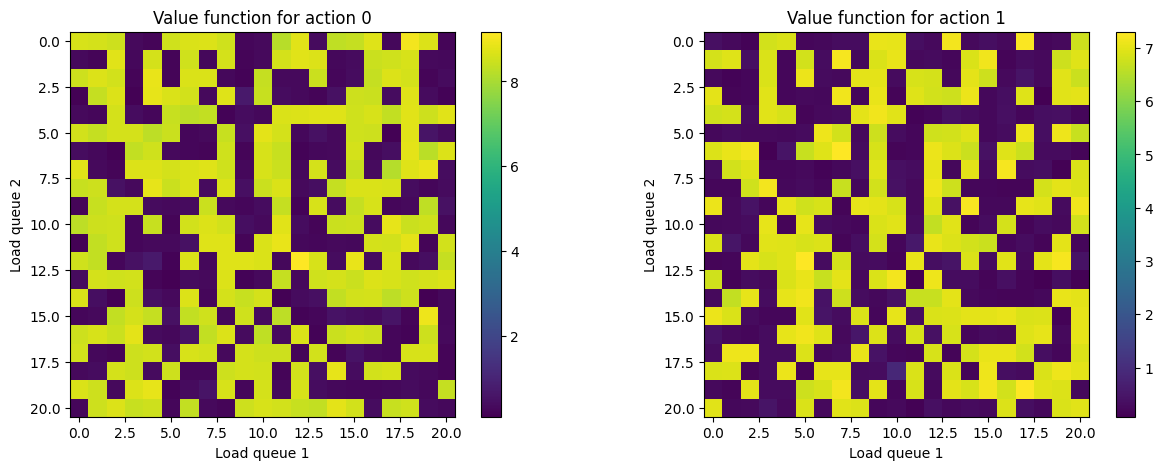

In [108]:
# Plot the value function
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(V[:, :, 0])
ax[0].set_xlabel("Load queue 1")
ax[0].set_ylabel("Load queue 2")
ax[0].set_title("Value function for action 0")
ax[1].imshow(V[:, :, 1])
ax[1].set_xlabel("Load queue 1")
ax[1].set_ylabel("Load queue 2")
ax[1].set_title("Value function for action 1")
plt.colorbar(ax[0].imshow(V[:, :, 0]), ax=ax[0])
plt.colorbar(ax[1].imshow(V[:, :, 1]), ax=ax[1])
plt.show()

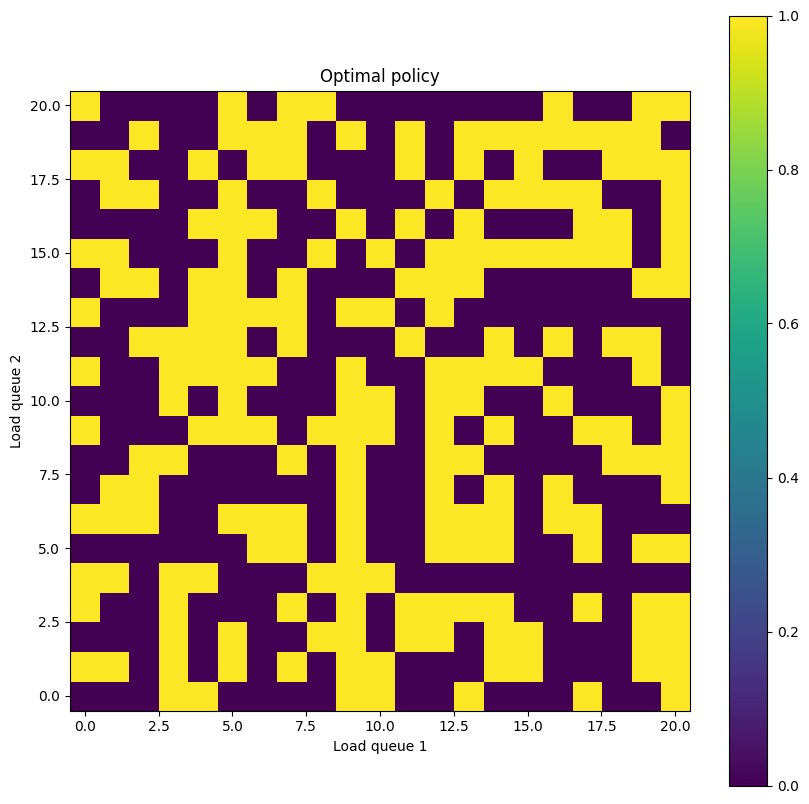

In [109]:
# Plot the optimal policy
fig, ax = plt.subplots(figsize=(10, 10))
plt.xlim(-0.5, Q1_max +0.5)
plt.ylim(-0.5, Q2_max +0.5)
plt.xlabel("Load queue 1")
plt.ylabel("Load queue 2")
plt.title("Optimal policy")
plt.imshow(np.argmax(policy, axis=2))
plt.colorbar()
plt.show()

In [84]:
# Simulate
N = 1000000
rewards, actions, load_1, load_2 = simulateLoadBalencing(lambdA, mu1, mu2, gamma, Q1_max, Q2_max, N, "optimal_policy")
# Plot
plotResults(rewards, actions, load_1, load_2, N)

AttributeError: 'LoadBalencingEnv' object has no attribute 'get_optimal_action'

In [ ]:
# Plot trajectory
plotTrajectory(load_1, load_2, N, Q1_max, Q2_max)